In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
%matplotlib inline

import zipfile

# Data Sampling & Collection

This project uses three main datasets, one of which provides global temperature data, while the other contains electricity load data for the PG&E territory, while the last contains the spatial boundaries of the PG&E territory. 

- The **temperature data** were retrieved from the National Oceanic and Atmospheric Administration (NOAA) Global Historical Climatology Network (GHCN), and reflect average daily temperature measured by GHCN weather stations across the globe from January to October 2020 ([NOAA, n.d.](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn)); this dataset was retrieved, processed, and made available by the Data 100/200 course staff. 

- The **load data** were retrieved from the U.S. Energy Information Administration (EIA), and reflect hourly electricity demand in megawatt-hours (MWh) for the PG&E service territory from July 2018 to April 2021 ([EIA, 2021](https://www.eia.gov/opendata/qb.php?category=3390291&sdid=EBA.CISO-PGAE.D.HL)). 

- The **PG&E service territory boundaries** were extracted from a geospatial shapefile of California electric utility service areas which was retrieved from the California State Geoportal ([CEC, 2020](https://gis.data.ca.gov/datasets/b95ca182aa254c3db8ad4d92bd32a73c_0?geometry=-161.087%2C31.071%2C-77.459%2C43.276)). 

Two potential sources of bias were identifeid: 
- Because the temperature data used are from 2020, the demand data were edited to only include 2020 data, and the model was eventually fit on 2020 data. However, given that the COVID-19 pandemic has altered electricity demand patterns, the model may be biased toward capturing demand patterns characteristic of 2020, and may have limited generalizability to other years. 
- The model is trained on data from the PG&E territory. As a result, it may have limited generalizability to demand associated with other electric utilities. 

In [2]:
# Read in datasets
weather = pd.read_csv("data/daily_global_weather_2020.csv")
pge_demand = pd.read_csv("data/PGE_Demand.csv")


In [3]:
# Print dataset column names
datasets = [weather, pge_demand] #emiss, emiss_facilities, aq, 
[i.columns.values for i in datasets]

[array(['Unnamed: 0', 'Station', 'Date', 'TAVG', 'Latitude', 'Longitude',
        'Elevation', 'PRCP'], dtype=object),
 array(['date', 'MWh'], dtype=object)]

# Data Cleaning & Exploratory Data Analysis

- The following sections describe data cleaning and exploratory data analysis (EDA) conducted for each analysis, first for the temperature data, and then the demand data. 
- After exploring and cleaning the datasets individually, the two datasets were combined, and relationships between demand and temperature and historical demand were explored. 
- Notably, the temperature and demand data differ in terms of spatial and temporal granularity, and had to be aligned before merging
    - The temperature data are at the daily scale for 10 months in 2020. They're available for individual weather stations located around the globe, including 12 within the PG&E territory. 
    - The demand data are at the hourly scale for 2018 through 2021. They're aggregated to the PG&E service territory level, which covers much of Northern California. 
    - As a result, the temperature data were modified to only include weather stations within the PG&E territory
    - Similarly, the demand data were modified to only include data for 2020, and eventually only include data from dates included in the temperature dataset
- Null values & outliers were explored for both datasets
    - Both the temperature and demand datasets were searched for null values; none were identified
    - Based on visualizations, all temperature and demand values appear to be plausible, real values
    - However, outliers were identified for the temperature and demand data. When forecasting electricity demand, it behooves utilities to accurately forecast demand even on days when tempeature and demand are anomalously low or high; this isparticularly relevant given projected increases in temperature extremes due to a changing climate. As a result, for both temperature and demand data, data frames were created for the model that include outliers and that exclude outliers, allowing for a comparison between a model fit on data including outliers and one fit on data excluding outliers. 

**Exploring, Cleaning, & Pre-processing Temperature Data**

First, the weather data were explored, spatially and temporally. The precipitation and temperature values were also plotted. 

In [4]:
weather.head(5)

,Unnamed: 0,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


In [5]:
# Limit weather dataframe to U.S. stations
weather['Country'] = weather['Station'].str[:2]
weather = weather[weather['Country']=='US']

In [6]:
# Determine weather data date range
weather_date_min = weather['Date'].min()
weather_date_max = weather['Date'].max()
weather_date_min, weather_date_max

('2020-01-01', '2020-10-22')

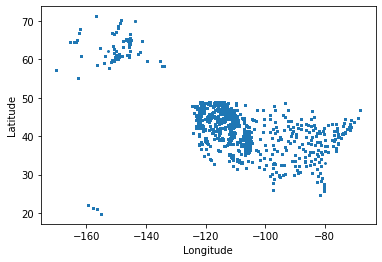

In [7]:
# Plot weather to confirm that we've extracted the U.S. stations
plt.scatter(weather['Longitude'], weather['Latitude'], s = 0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

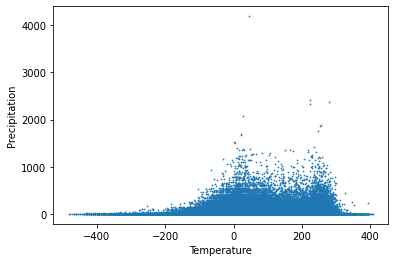

In [8]:
# Plot precip and temperature data
plt.scatter(weather['TAVG'], weather['PRCP'], s = 0.5)
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.show()

In order to limit the data to the PG&E service territory, a shapefile of California electric utility service areas was imported and plotted for visualization. 

In [9]:
pip install pyshp

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Extract CA electric utility service area shapefile from zip file
import zipfile

from pathlib import Path
data_dir = Path('.')
data_dir.mkdir(exist_ok = True)
file_path = data_dir / Path('data/California_Electric_Utility_Service_Areas.zip')
dest_path = file_path
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = my_zip.namelist()
data_dir = Path('.')
my_zip.extractall(data_dir/Path('data'))
#!ls {data_dir / Path("data")}

In [11]:
# Extract PG&E service area from shapefile of CA utility service areas
import geopandas as gpd
fp = "data/California_Electric_Utility_Service_Areas.shp"
data = gpd.read_file(fp)
pge = data[data['Acronym'] == 'PG&E']
# Change projectetion from cartesian to geodetic lat/lon to match weather data
pge = pge.to_crs('EPSG:4326') 
pge

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


,OBJECTID,Acronym,Utility,Type,Retail_Sal,Number_Acc,Shape__Are,Shape__Len,geometry
56,57,PG&E,Pacific Gas & Electric Company,IOU,82224.32041,5479894.0,2.819199e+11,8.056170e+06,"MULTIPOLYGON (((-124.16609 41.09473, -124.1664..."


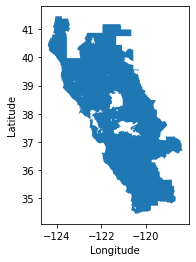

In [12]:
# Plot PG&E service area
pge.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The PG&E boundaries were extracted and used to visualize weather stations within or nearby the PG&E service territory. 

In [13]:
# Get exterior coordinates for polygons in PG&E service territory
points = []
for polygon in pge.loc[56, 'geometry']:
    points.extend(polygon.exterior.coords[:-1])
points = np.asarray(points)
lon_min = min(points[:,0])
lon_max = max(points[:,0])
lat_min = min(points[:,1])
lat_max = max(points[:,1])
lon_min, lon_max, lat_min, lat_max

(-124.41516217245281,
 -118.33472877146838,
 34.44205283891856,
 41.465850525676665)

In [14]:
# Create weather data frame of stations within rectangle created by PG&E service territory min/max bounds
weather_pge = weather[(weather['Latitude'] >= lat_min) & (weather['Latitude'] <= lat_max)
                      & (weather['Longitude'] >= lon_min) & (weather['Longitude'] <= lon_max)]

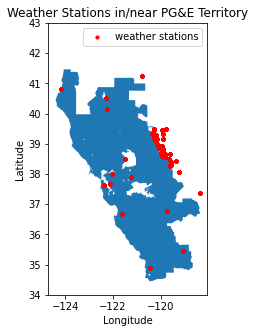

In [15]:
# Plot weather stations within rectangle created by min/max lat/lon of pg&e service territory
plt.rcParams["figure.figsize"] = (5, 5)
pge.plot()
plt.scatter(weather_pge['Longitude'], weather_pge['Latitude'], c = 'red', s = 10, label = 'weather stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34, 43)
plt.legend()
plt.title('Weather Stations in/near PG&E Territory')
plt.show()

In [16]:
# Create GeoDataFrame of unique weather stations in/nearby PG&E territory
weather_pge_2 = weather_pge.groupby(['Station']).agg(np.mean)
weather_pge_gdf_2 = gpd.GeoDataFrame(weather_pge_2, geometry = gpd.points_from_xy(weather_pge_2.Longitude, 
                                                                                  weather_pge_2.Latitude))
weather_pge_gdf_2 = weather_pge_gdf_2.set_crs("EPSG:4326")

The weather stations were then spatially joined with PG&E GeoDataFrame, and this was used to create a data frame of only weather stations within the PG&E territory. Based on this, a data frame of all temperature readings from weather stations within the PG&E territory was created.

In [17]:
# Create dataframe of weather stations in PG&E territory using spatial join
from geopandas.tools import sjoin
StationsInPGE = sjoin(weather_pge_gdf_2, pge, how = 'left')
StationsInPGE = StationsInPGE[StationsInPGE['Acronym']=='PG&E']

In [18]:
# Create dataframe of all weather station data for stations in PG&E territory based on spatial join
weather_in_pge = weather_pge[weather_pge['Station'].isin(StationsInPGE.index)]
weather_in_pge = weather_in_pge.drop(columns=['Unnamed: 0'])
# Add tavg in units of Celcius (rather than C*100)
weather_in_pge['tavg'] = weather_in_pge['TAVG']/10
weather_in_pge = weather_in_pge.rename(columns = {'TAVG': 'TAVG_og_10C'})
weather_in_pge.head(5)

,Station,Date,TAVG_og_10C,Latitude,Longitude,Elevation,PRCP,Country,tavg
3106,USS0019L05S,2020-01-01,13.0,38.6100,-119.9200,2455.8,0.0,US,1.3
3151,USS0020K31S,2020-01-01,15.0,39.3300,-120.3700,2089.4,25.0,US,1.5
3153,USS0020L06S,2020-01-01,36.0,38.8500,-120.0800,2337.8,0.0,US,3.6
3305,USW00024213,2020-01-01,111.0,40.8097,-124.1603,6.1,86.0,US,11.1
6538,USS0019L05S,2020-01-02,7.0,38.6100,-119.9200,2455.8,0.0,US,0.7


Below is a plot of all weather stations within the PG&E territory

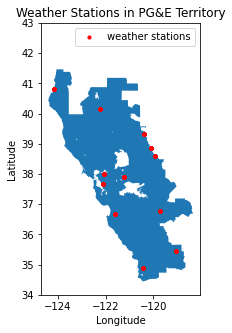

In [19]:
# Plot weather stations within pg&e service territroy
plt.rcParams["figure.figsize"] = (5, 5)
pge.plot()
plt.scatter(weather_in_pge['Longitude'], weather_in_pge['Latitude'], c = 'red', s = 10, label = 'weather stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.ylim(34, 43)
plt.legend()
plt.title('Weather Stations in PG&E Territory')
plt.show()

In order to allow for temporal analysis, a the temperature data frame date column was converted to datetime, localized to Pacific Time, then time.localtime() was used to extract a range of temporal variables (e.g., month, day of week, hour of day, etc.). 

In [20]:
from datetime import datetime
#from datetime import date
import time
import pytz
from pytz import timezone
pst = timezone('US/Pacific')

In [21]:
# Add datetime columns
weather_in_pge['date_datetime'] = pd.to_datetime(weather_in_pge['Date'], format = '%Y-%m-%d')
weather_in_pge['date_datetime'] = weather_in_pge['date_datetime'].dt.tz_localize(pst, 
                                                                                 ambiguous = False)

In [22]:
# Define function to add additional relevant columns based on datetime column

def localtime_cols(df, datetime_col):
    """
    Inputs: DataFrame, Name of column containing date in datetime
    Output: Dataframe containing various columns derived from datetime column
            Description of localtime outputs: https://www.geeksforgeeks.org/python-time-localtime-method/
    """
    df['UNIX_PST'] = (df[datetime_col].view(int)/1000000000).astype(int)
    df['localtime'] = df['UNIX_PST'].apply(lambda x: time.localtime(x))
    df['year'] = df['localtime'].apply(lambda x: x[0]) 
    df['month'] = df['localtime'].apply(lambda x: x[1]) #Range [1, 12]
    df['week_of_year'] = (df['localtime'].apply(lambda x: x[7])/7).astype(int) #Range [0, 52]
    df['day_of_week'] = df['localtime'].apply(lambda x: x[6]) #Monday is 0, Sunday is 6
    df['hour'] = df['localtime'].apply(lambda x: x[3]) #Range [0, 23]
    df['weekday_weekend'] = np.where(df['day_of_week']<5, 'Weekday', 'Weekend')
    df['day_of_year'] = df['localtime'].apply(lambda x: x[7]) # Range [1, 366]
    return df

localtime_cols(weather_in_pge, 'date_datetime').head(5)

,Station,Date,TAVG_og_10C,Latitude,Longitude,Elevation,PRCP,Country,tavg,date_datetime,UNIX_PST,localtime,year,month,week_of_year,day_of_week,hour,weekday_weekend,day_of_year
3106,USS0019L05S,2020-01-01,13.0,38.6100,-119.9200,2455.8,0.0,US,1.3,2020-01-01 00:00:00-08:00,1577865600,"(2020, 1, 1, 0, 0, 0, 2, 1, 0)",2020,1,0,2,0,Weekday,1
3151,USS0020K31S,2020-01-01,15.0,39.3300,-120.3700,2089.4,25.0,US,1.5,2020-01-01 00:00:00-08:00,1577865600,"(2020, 1, 1, 0, 0, 0, 2, 1, 0)",2020,1,0,2,0,Weekday,1
3153,USS0020L06S,2020-01-01,36.0,38.8500,-120.0800,2337.8,0.0,US,3.6,2020-01-01 00:00:00-08:00,1577865600,"(2020, 1, 1, 0, 0, 0, 2, 1, 0)",2020,1,0,2,0,Weekday,1
3305,USW00024213,2020-01-01,111.0,40.8097,-124.1603,6.1,86.0,US,11.1,2020-01-01 00:00:00-08:00,1577865600,"(2020, 1, 1, 0, 0, 0, 2, 1, 0)",2020,1,0,2,0,Weekday,1
6538,USS0019L05S,2020-01-02,7.0,38.6100,-119.9200,2455.8,0.0,US,0.7,2020-01-02 00:00:00-08:00,1577952000,"(2020, 1, 2, 0, 0, 0, 3, 2, 0)",2020,1,0,3,0,Weekday,2


This data frame was used to determine the time range of the weather data available for the PG&E territory, to identify any missing values, and to plot each temperature reading by month to visually identify values that were clearly incorrect. No null temperature readings were identified, and all temperature readings seemed to be plausible true values.

In [23]:
# Determine weather data date range in datetime
weather_pge_date_min = weather_in_pge['date_datetime'].min()
weather_pge_date_max = weather_in_pge['date_datetime'].max()
weather_pge_date_min, weather_pge_date_max

(Timestamp('2020-01-01 00:00:00-0800', tz='US/Pacific'),
 Timestamp('2020-10-22 00:00:00-0700', tz='US/Pacific'))

In [24]:
# Find null values
sum(weather_in_pge['tavg'].isnull())

0

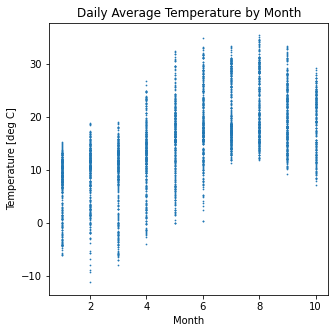

In [25]:
# Plot temp data by month to visualize data & look for outliers
plt.scatter(weather_in_pge['month'],weather_in_pge['tavg'], s = 0.5) 
plt.xlabel('Month')
plt.ylabel('Temperature [deg C]')
plt.title('Daily Average Temperature by Month')
plt.show()

A function was defined to remove outliers from the temperature dataset, and identify the number of outliers removed. Outliers were removed by month, given that there appeared to be possible outliers during June that might not be removed if the threshold (Q 1/3 -/+ 1.5 IQR) were calculated by considering all points throughout the year. 

In [26]:
# Remove outliers according to Q1/3 -/+ 1.5xIQR outlier definition

def remove_outliers(df, group, val):
    """
    Inputs: df = DataFrame
            group = Column name to use to group outlier removal
            val = column with values for outlier removal
    Outputs: DataFrame with outliers removed, number of outliers removed
    """
    for i in df[group].unique():
        df_group = df[df[group]==i]
        q1, q3 = df_group[val].quantile([0.25, 0.75])
        iqr = q3 - q1
        outlier_upper = q3 + 1.5*iqr
        outlier_lower = q1 - 1.5*iqr
        if i == 1:
            df_wo_outliers = df_group[(df_group[val]>outlier_lower) & (df_group[val]<outlier_upper)]
        else:
            df_wo_outliers = df_wo_outliers.append(df_group[(df_group[val]>outlier_lower) & (df_group[val]<outlier_upper)])
    print('Number of Outliers Removed:', len(df) - len(df_wo_outliers))
    return df_wo_outliers

weather_in_pge_wo_outliers = remove_outliers(df = weather_in_pge, group = 'month', val = 'tavg')

Number of Outliers Removed: 58


The new weather data set without outliers was plotted. Because all of the values in the original dataset seemed to be plausible values, the analysis was continued using both the original dataset without outliers removed and this dataset with outliers removed

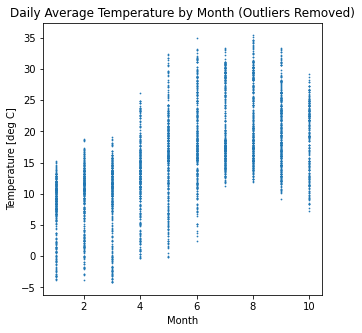

In [27]:
# Plot temp data by month to visualize data with outliers removed
plt.scatter(weather_in_pge_wo_outliers['month'],weather_in_pge_wo_outliers['tavg'], s = 0.5) 
plt.xlabel('Month')
plt.ylabel('Temperature [deg C]')
plt.title('Daily Average Temperature by Month (Outliers Removed)')
plt.show()

To prepare the weather data for the linear regression, the weather data were grouped by the datetime column, and the average, maximum, and minimum temperature value was calculated across the weather stations for each day. Additionally, for each entry, the mean, minimum, and max of the weather station readings for the previous day’s average temperature were added as columns, and the same was done for the day before that. 

In [28]:
# Create dataframe of daily average, max, and min average temperature across stations (including outliers)
weather_in_pge_date = weather_in_pge[['date_datetime', 'tavg']].groupby(['date_datetime']).agg({'tavg' : [np.mean, np.max, np.min]})
weather_in_pge_date.columns = weather_in_pge_date.columns.get_level_values(1)
weather_in_pge_date = weather_in_pge_date.rename(columns = {'mean': 'tavg_mean', 'amax': 'tavg_max', 'amin': 'tavg_min'})
weather_in_pge_date.reset_index(inplace=True)
weather_in_pge_date.head(5)

,date_datetime,tavg_mean,tavg_max,tavg_min
0,2020-01-01 00:00:00-08:00,4.375000,11.1,1.3
1,2020-01-02 00:00:00-08:00,8.227273,14.3,0.7
2,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7
3,2020-01-04 00:00:00-08:00,8.275000,11.7,0.2
4,2020-01-05 00:00:00-08:00,6.816667,11.4,-2.8


In [29]:
# Add mean/max/min for previous day (yesterday) and day before that (day before yesterday)
n = len(weather_in_pge_date)
base_col_names = ['tavg_mean','tavg_max', 'tavg_min']
new_col_names = ['tavg_mean_yest', 'tavg_max_yest', 'tavg_min_yest']
for i in range(3):
    nan_list = ['nan']
    nan_list.extend(weather_in_pge_date[base_col_names[i]][0:n-1].tolist())
    weather_in_pge_date[new_col_names[i]] = nan_list
new_col_names_2 = ['tavg_mean_dbfyest', 'tavg_max_dbfyest', 'tavg_min_dbfyest']
for i in range(3):
    nan_list = ['nan', 'nan']
    nan_list.extend(weather_in_pge_date[base_col_names[i]][0:n-2].tolist())
    weather_in_pge_date[new_col_names_2[i]] = nan_list
weather_in_pge_date = localtime_cols(weather_in_pge_date, 'date_datetime')
weather_in_pge_date = weather_in_pge_date.drop(weather_in_pge_date.columns[range(10, 18)], axis = 1)
weather_in_pge_date.head(5)

,date_datetime,tavg_mean,tavg_max,tavg_min,tavg_mean_yest,tavg_max_yest,tavg_min_yest,tavg_mean_dbfyest,tavg_max_dbfyest,tavg_min_dbfyest,day_of_year
0,2020-01-01 00:00:00-08:00,4.375000,11.1,1.3,nan,nan,nan,nan,nan,nan,1
1,2020-01-02 00:00:00-08:00,8.227273,14.3,0.7,4.375000,11.1,1.3,nan,nan,nan,2
2,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375000,11.1,1.3,3
3,2020-01-04 00:00:00-08:00,8.275000,11.7,0.2,8.658333,12.9,2.7,8.227273,14.3,0.7,4
4,2020-01-05 00:00:00-08:00,6.816667,11.4,-2.8,8.275000,11.7,0.2,8.658333,12.9,2.7,5


The same was done for the weather dataframe with outliers removed

In [30]:
# Create dataframe of daily average, max, and min average temperature across stations (excluding outliers)
weather_in_pge_date_wo_outliers = weather_in_pge_wo_outliers[['date_datetime', 'tavg']].groupby(['date_datetime']).agg({'tavg' : [np.mean, np.max, np.min]})
weather_in_pge_date_wo_outliers.columns = weather_in_pge_date_wo_outliers.columns.get_level_values(1)
weather_in_pge_date_wo_outliers = weather_in_pge_date_wo_outliers.rename(columns = {'mean': 'tavg_mean', 'amax': 'tavg_max', 'amin': 'tavg_min'})
weather_in_pge_date_wo_outliers.reset_index(inplace=True)
weather_in_pge_date_wo_outliers.head(5)

,date_datetime,tavg_mean,tavg_max,tavg_min
0,2020-01-01 00:00:00-08:00,4.375000,11.1,1.3
1,2020-01-02 00:00:00-08:00,8.227273,14.3,0.7
2,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7
3,2020-01-04 00:00:00-08:00,8.275000,11.7,0.2
4,2020-01-05 00:00:00-08:00,6.816667,11.4,-2.8


In [31]:
# Add mean/max/min for previous day (yesterday) and day before that (day before yesterday)
n = len(weather_in_pge_date_wo_outliers)
base_col_names = ['tavg_mean','tavg_max', 'tavg_min']
new_col_names = ['tavg_mean_yest', 'tavg_max_yest', 'tavg_min_yest']
for i in range(3):
    nan_list = ['nan']
    nan_list.extend(weather_in_pge_date_wo_outliers[base_col_names[i]][0:n-1].tolist())
    weather_in_pge_date_wo_outliers[new_col_names[i]] = nan_list
new_col_names_2 = ['tavg_mean_dbfyest', 'tavg_max_dbfyest', 'tavg_min_dbfyest']
for i in range(3):
    nan_list = ['nan', 'nan']
    nan_list.extend(weather_in_pge_date_wo_outliers[base_col_names[i]][0:n-2].tolist())
    weather_in_pge_date_wo_outliers[new_col_names_2[i]] = nan_list
weather_in_pge_date_wo_outliers = localtime_cols(weather_in_pge_date_wo_outliers, 'date_datetime')
weather_in_pge_date_wo_outliers = weather_in_pge_date_wo_outliers.drop(weather_in_pge_date_wo_outliers.columns[range(10, 18)], axis = 1)
weather_in_pge_date_wo_outliers.head(5)

,date_datetime,tavg_mean,tavg_max,tavg_min,tavg_mean_yest,tavg_max_yest,tavg_min_yest,tavg_mean_dbfyest,tavg_max_dbfyest,tavg_min_dbfyest,day_of_year
0,2020-01-01 00:00:00-08:00,4.375000,11.1,1.3,nan,nan,nan,nan,nan,nan,1
1,2020-01-02 00:00:00-08:00,8.227273,14.3,0.7,4.375000,11.1,1.3,nan,nan,nan,2
2,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375000,11.1,1.3,3
3,2020-01-04 00:00:00-08:00,8.275000,11.7,0.2,8.658333,12.9,2.7,8.227273,14.3,0.7,4
4,2020-01-05 00:00:00-08:00,6.816667,11.4,-2.8,8.275000,11.7,0.2,8.658333,12.9,2.7,5


**Exploring, Cleaning, & Pre-processing Demand Data**

The PG&E demand data were explored, and as with the weather data, the date column was converted to datetime, localized to Pacific Time, and time.localtime() was applied to extract additional temporal variables for each entry (e.g., day of week, month, etc.). 

In [32]:
pge_demand.head(5)

,date,MWh
0,4/25/2021 0:00,10028
1,4/24/2021 23:00,10625
2,4/24/2021 22:00,11135
3,4/24/2021 21:00,11467
4,4/24/2021 20:00,11236


In [33]:
# Add columns to demand data creating individual columns for year, month, week of year, day of week, hour, etc.
pge_demand = pd.read_csv("data/PGE_Demand.csv")
pge_demand['date_datetime'] = pge_demand['date']
pge_demand['date_datetime'] = pd.to_datetime(pge_demand['date_datetime'], format = '%m/%d/%Y %H:%M')
pge_demand['date_datetime'] = pge_demand['date_datetime'].dt.tz_localize(pst, 
                                                                         ambiguous = False, 
                                                                         nonexistent = 'shift_forward')
localtime_cols(pge_demand, 'date_datetime')
pge_demand = pge_demand.sort_values(['date_datetime'])
pge_demand.head(5)

,date,MWh,date_datetime,UNIX_PST,localtime,year,month,week_of_year,day_of_week,hour,weekday_weekend,day_of_year
24655,7/1/2018 1:00,12522,2018-07-01 01:00:00-07:00,1530432000,"(2018, 7, 1, 1, 0, 0, 6, 182, 1)",2018,7,26,6,1,Weekend,182
24654,7/1/2018 2:00,11745,2018-07-01 02:00:00-07:00,1530435600,"(2018, 7, 1, 2, 0, 0, 6, 182, 1)",2018,7,26,6,2,Weekend,182
24653,7/1/2018 3:00,11200,2018-07-01 03:00:00-07:00,1530439200,"(2018, 7, 1, 3, 0, 0, 6, 182, 1)",2018,7,26,6,3,Weekend,182
24652,7/1/2018 4:00,10822,2018-07-01 04:00:00-07:00,1530442800,"(2018, 7, 1, 4, 0, 0, 6, 182, 1)",2018,7,26,6,4,Weekend,182
24651,7/1/2018 5:00,10644,2018-07-01 05:00:00-07:00,1530446400,"(2018, 7, 1, 5, 0, 0, 6, 182, 1)",2018,7,26,6,5,Weekend,182


The PG&E demand data timeframe was compared against that of the weather data, to assess what data could be used in the linear regression model. Based on this, a data frame was created for the PG&E demand 2020 data. The data were also searched for null values; none were identified. 

In [34]:
# Compare dates for demand and weather data
demand_date_min = pge_demand['date_datetime'].min()
demand_date_max = pge_demand['date_datetime'].max()
print('Weather date min & max:', weather_date_min, weather_date_max)
print('Demand date min & max:', demand_date_min, demand_date_max)

Weather date min & max: 2020-01-01 2020-10-22
Demand date min & max: 2018-07-01 01:00:00-07:00 2021-04-25 00:00:00-07:00


In [35]:
# Create dataframe for 2020 demand data
pge_demand_2020 = pge_demand[pge_demand['year']==2020]

In [36]:
# Find null values
sum(pge_demand_2020['MWh'].isnull())

0

Visualizations were then used to determine if there were any clearly incorrect data points, and to explore relationships between hourly demand and temporal variables (e.g., weekday/weekend, day of time, hour of day, etc.). To accomplish this, the data were plotted by day of week, by weekday vs. weekend, and by month. Based on the plots, the demand data appear to be plausible, true values. Additionally, they exhibit a clear relationship to hour of day (i.e., a typical morning and evening peak) and month (i.e., summer and fall months exhibit higher demand, while winter and spring months exhibit lower demand). 

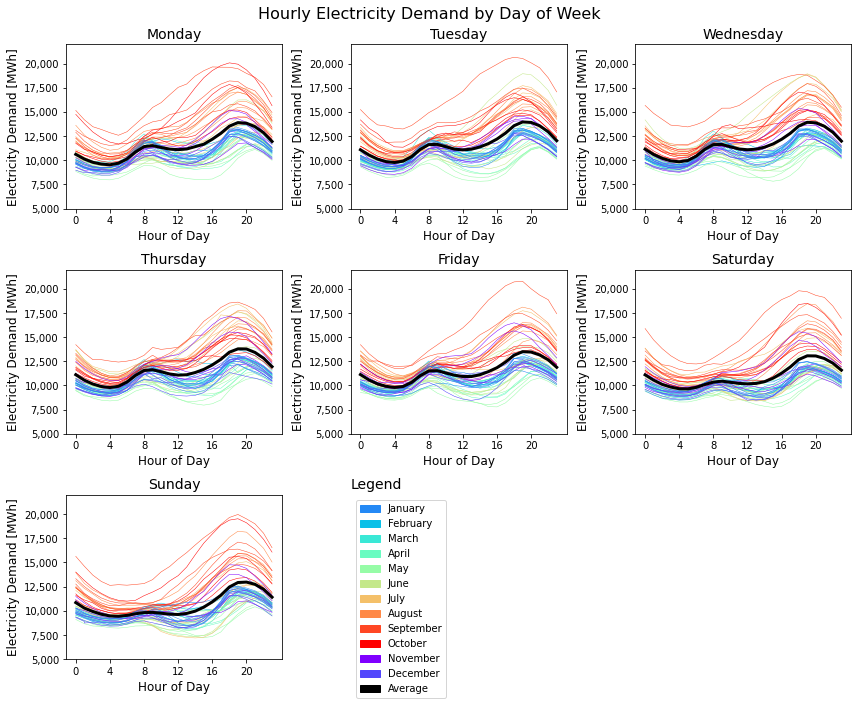

In [37]:
# Create function to plot figures of hourly electricity demand for each day of the week
import matplotlib.patches as mpatches

def plot_hourly_energy_dow(matrix):
    """
    Inputs: DataFrame with one year (or less) of electricity demand data with columns 
            'month', 'day_of_week', 'week_of_year', 'hour', and 'MWh'
    Output: Plots of hourly electricity demand for each day of week for weach week in the DataFrame
    """
    fig = plt.figure(figsize = (12, 10))
    fig.suptitle('Hourly Electricity Demand by Day of Week', fontsize = 16)
    fig_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
             'October', 'November', 'December', 'Average']
    colormap = plt.cm.rainbow
    colors = [colormap(i) for i in np.linspace(0, 1, 12)]
    #colors  = ['pink', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'purple', 'magenta']
    for day in matrix['day_of_week'].unique():
        ax = fig.add_subplot(3, 3, day+1)
        ax.set_title(fig_names[day], fontsize = 14)
        ax.set_xlabel('Hour of Day', fontsize = 12)
        ax.set_ylabel('Electricity Demand [MWh]', fontsize = 12)
        ax.set_ylim(5000, 22000)
        ax.set_xticks(range(0, 24, 4))
        matrix_day = matrix[matrix['day_of_week']==day]
        day_avg = matrix_day.groupby('hour').mean()
        day_avg = day_avg['MWh']
        for week in matrix['week_of_year'].unique():
            matrix_day_week = matrix_day[matrix_day['week_of_year']==week]
            month = int(np.nan_to_num(matrix_day_week['month'].mean()))
            ax.plot(matrix_day_week['hour'], matrix_day_week['MWh'], linewidth = 0.5, 
                    color = colors[month-10], label = month)
        ax.plot(day_avg.index, day_avg, color = 'black', linewidth = 3, label = 'Average')
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax = fig.add_subplot(3, 3, 8)
    ax.set_title('Legend', loc = 'left', fontsize = 14)
    ax.axis('off')
    for i in np.arange(len(months)-1):
        months[i] = mpatches.Patch(color = colors[i-10], label = months[i])
    months[len(months)-1] = mpatches.Patch(color = 'black', label = 'Average')
    plt.legend(handles = months, loc = 'upper left')
    plt.tight_layout(pad = 1)  
    plt.show()

    
plot_hourly_energy_dow(pge_demand_2020)

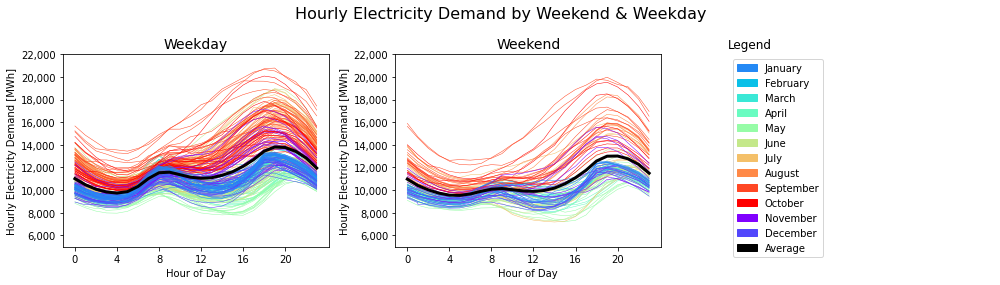

In [38]:
def plot_hourly_energy_weekend_weekday(matrix):
    """
    Inputs: DataFrame with one year (or less) of electricity demand data with columns 
            'month', weekday_weekend', 'week_of_year', 'hour', and 'MWh'
    Output: Plots of hourly electricity demand by weekday and weekend for each day in the DataFrame
    """
    fig = plt.figure(figsize = (14, 4))
    fig.suptitle('Hourly Electricity Demand by Weekend & Weekday', fontsize = 16)
    fig_names = ['Weekday', 'Weekend']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
             'October', 'November', 'December', 'Average']
    colormap = plt.cm.rainbow
    colors = [colormap(i) for i in np.linspace(0, 1, 12)]
    day_type = ['Weekday', 'Weekend']
    for day in [0, 1]:
        ax = fig.add_subplot(1, 3, day+1)
        ax.set_title(fig_names[day], fontsize = 14)
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Hourly Electricity Demand [MWh]')
        ax.set_ylim(5000, 22000)
        ax.set_xticks(range(0, 24, 4))
        matrix_day = matrix[matrix['weekday_weekend']==day_type[day]]
        day_avg = matrix_day.groupby('hour').mean()
        day_avg = day_avg['MWh']
        for doy in matrix['day_of_year'].unique():
            matrix_day_doy = matrix_day[matrix_day['day_of_year']==doy]
            month = int(np.nan_to_num(matrix_day_doy['month'].mean()))
            ax.plot(matrix_day_doy['hour'], matrix_day_doy['MWh'], linewidth = 0.5, 
                    color = colors[month-10], label = month)
        ax.plot(day_avg.index, day_avg, color = 'black', linewidth = 3, label = 'Average')
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Legend', loc = 'left')
    ax.axis('off')
    for i in np.arange(len(months)-1):
        months[i] = mpatches.Patch(color = colors[i-10], label = months[i])
    months[len(months)-1] = mpatches.Patch(color = 'black', label = 'Average')
    plt.legend(handles = months, loc = 'upper left')
    plt.tight_layout()  
    plt.show()

    
plot_hourly_energy_weekend_weekday(pge_demand_2020)

As with the weather data, a dataframe without outliers was created. Similar to the temperature data, outliers were calculated for each month, and were calculated at the daily scale (to allow for plots similar to those above) based on mean daily load. To do this, the PG&E dataframe was grouped by day of year, aggregating by calculating the mean. Outliers were then removed from this dataframe. This was then used to remove those outlier days from the original PG&E 2020 hourly demand dataframe. 

In [39]:
# Create daily demand dataframe from hourly 
pge_demand_2020_daily = pge_demand_2020.groupby(['day_of_year']).mean()
pge_demand_2020_daily.head(5)

,MWh,UNIX_PST,year,month,week_of_year,day_of_week,hour
day_of_year,,,,,,,
1,10117.458333,1.577907e+09,2020.0,1.0,0.0,2.0,11.5
2,10578.458333,1.577993e+09,2020.0,1.0,0.0,3.0,11.5
3,10542.791667,1.578080e+09,2020.0,1.0,0.0,4.0,11.5
4,10047.875000,1.578166e+09,2020.0,1.0,0.0,5.0,11.5
5,10045.750000,1.578253e+09,2020.0,1.0,0.0,6.0,11.5


In [40]:
# Remove outliers according to Q1/3 -/+ 1.5xIQR outlier definition
pge_demand_2020_daily_wo_outliers = remove_outliers(df = pge_demand_2020_daily, group = 'month', val = 'MWh')
demand_non_outlier_days = pge_demand_2020_daily_wo_outliers.index
demand_non_outlier_days

Number of Outliers Removed: 8


Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
           dtype='int64', name='day_of_year', length=358)

In [41]:
# Remove outliers from hourly demand dataframe
pge_demand_2020_wo_outliers = pge_demand_2020[pge_demand_2020['day_of_year'].isin(demand_non_outlier_days)]
pge_demand_2020_wo_outliers.head(5)

,date,MWh,date_datetime,UNIX_PST,localtime,year,month,week_of_year,day_of_week,hour,weekday_weekend,day_of_year
11515,1/1/2020 0:00,10424,2020-01-01 00:00:00-08:00,1577865600,"(2020, 1, 1, 0, 0, 0, 2, 1, 0)",2020,1,0,2,0,Weekday,1
11514,1/1/2020 1:00,10285,2020-01-01 01:00:00-08:00,1577869200,"(2020, 1, 1, 1, 0, 0, 2, 1, 0)",2020,1,0,2,1,Weekday,1
11513,1/1/2020 2:00,9934,2020-01-01 02:00:00-08:00,1577872800,"(2020, 1, 1, 2, 0, 0, 2, 1, 0)",2020,1,0,2,2,Weekday,1
11512,1/1/2020 3:00,9645,2020-01-01 03:00:00-08:00,1577876400,"(2020, 1, 1, 3, 0, 0, 2, 1, 0)",2020,1,0,2,3,Weekday,1
11511,1/1/2020 4:00,9475,2020-01-01 04:00:00-08:00,1577880000,"(2020, 1, 1, 4, 0, 0, 2, 1, 0)",2020,1,0,2,4,Weekday,1


In [42]:
print('Number of outliers removed from hourly demand data: ', len(pge_demand_2020)-len(pge_demand_2020_wo_outliers))

Number of outliers removed from hourly demand data:  192


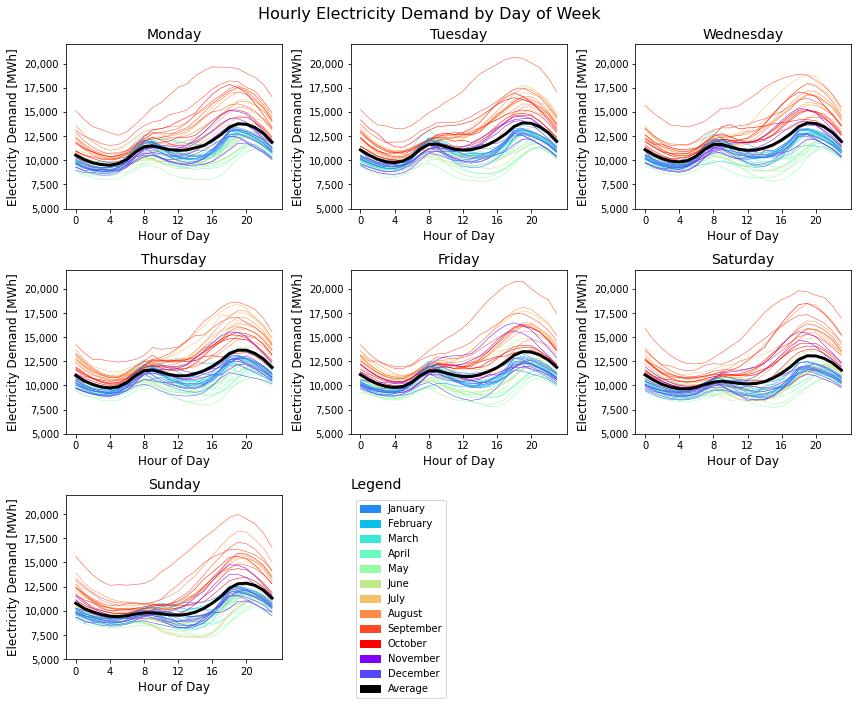

In [43]:
# Create same hourly plots as above using cleaned dataset (i.e., dataset without outliers)
plot_hourly_energy_dow(pge_demand_2020_wo_outliers)

The data were then prepared for the regression model by adding potential features, including for each entry, adding demand from the previous hour, demand from the same hour of the previous day, and demand from the same hour and same day of the previous week. 

In [44]:
# Sort pge_demand so that time progresses/increases
pge_demand = pge_demand.sort_values(['date_datetime'])
# Add in columns for demand for (1) previous hour, (2) same hour previous day, (3) same hour same dow previous week
n = len(pge_demand)
# Previous hour
nan_list = ['nan']
nan_list.extend(pge_demand['MWh'][0:n-1].tolist())
pge_demand['MWh_prev_hr'] = nan_list
# Same hour previous day
nan_list = ['nan']*24
nan_list.extend(pge_demand['MWh'][0:n-24].tolist())
pge_demand['MWh_same_hr_prev_day'] = nan_list
# Same hour same dow previous week
nan_list = ['nan']*24*7
nan_list.extend(pge_demand['MWh'][0:n-(24*7)].tolist())
pge_demand['MWh_same_hrday_prev_week'] = nan_list

**Combining Temperature & Demand Data, Visualizing Relationships, & Feature Engineering**

The temperature and demand data were combined into a single data frame, split into training and testing data, and then the training data were used to visualize relationships between the hourly demand, historical demand, and temperature to identify potential features. 

In [45]:
# Compare dates for demand and weather data
print('Weather date min & max:', weather_pge_date_min, weather_pge_date_max)
print('Demand date min & max:', demand_date_min, demand_date_max)

Weather date min & max: 2020-01-01 00:00:00-08:00 2020-10-22 00:00:00-07:00
Demand date min & max: 2018-07-01 01:00:00-07:00 2021-04-25 00:00:00-07:00


In [46]:
# Combine datasets
combined = pge_demand[(pge_demand['date_datetime']>=weather_pge_date_min) & 
                      (pge_demand['date_datetime']<=weather_pge_date_max)]
combined = combined.merge(weather_in_pge_date, how = 'left', left_on = 'day_of_year', right_on = 'day_of_year')
combined = combined[combined['day_of_year']>2]
combined.head(3)

,date,MWh,date_datetime_x,UNIX_PST,localtime,year,month,week_of_year,day_of_week,hour,...,date_datetime_y,tavg_mean,tavg_max,tavg_min,tavg_mean_yest,tavg_max_yest,tavg_min_yest,tavg_mean_dbfyest,tavg_max_dbfyest,tavg_min_dbfyest
48,1/3/2020 0:00,9999,2020-01-03 00:00:00-08:00,1578038400,"(2020, 1, 3, 0, 0, 0, 4, 3, 0)",2020,1,0,4,0,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3
49,1/3/2020 1:00,9455,2020-01-03 01:00:00-08:00,1578042000,"(2020, 1, 3, 1, 0, 0, 4, 3, 0)",2020,1,0,4,1,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3
50,1/3/2020 2:00,9038,2020-01-03 02:00:00-08:00,1578045600,"(2020, 1, 3, 2, 0, 0, 4, 3, 0)",2020,1,0,4,2,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3


In [47]:
# Split combined dataframe into test and train data

# Set random seed for reproducible results
np.random.seed(1337)

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split_point = int(data_len*0.8)
    train_indices = shuffled_indices[:split_point]
    test_indices = shuffled_indices[split_point:]
    train = data.iloc[train_indices]
    test = data.iloc[test_indices]
    return train, test
train, test = train_test_split(combined)

Create a version of the dataset that excludes demand and temperature outliers

In [48]:
# Remove day with temperature outliers
temp_non_outlier_days = weather_in_pge_date_wo_outliers['day_of_year']
combined_wo_outliers = combined[combined['day_of_year'].isin(temp_non_outlier_days) &
                                combined['day_of_year'].isin(demand_non_outlier_days)]
combined_wo_outliers.head(3)

,date,MWh,date_datetime_x,UNIX_PST,localtime,year,month,week_of_year,day_of_week,hour,...,date_datetime_y,tavg_mean,tavg_max,tavg_min,tavg_mean_yest,tavg_max_yest,tavg_min_yest,tavg_mean_dbfyest,tavg_max_dbfyest,tavg_min_dbfyest
48,1/3/2020 0:00,9999,2020-01-03 00:00:00-08:00,1578038400,"(2020, 1, 3, 0, 0, 0, 4, 3, 0)",2020,1,0,4,0,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3
49,1/3/2020 1:00,9455,2020-01-03 01:00:00-08:00,1578042000,"(2020, 1, 3, 1, 0, 0, 4, 3, 0)",2020,1,0,4,1,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3
50,1/3/2020 2:00,9038,2020-01-03 02:00:00-08:00,1578045600,"(2020, 1, 3, 2, 0, 0, 4, 3, 0)",2020,1,0,4,2,...,2020-01-03 00:00:00-08:00,8.658333,12.9,2.7,8.227273,14.3,0.7,4.375,11.1,1.3


In [49]:
# Split combined wo outliers dataframe into test and train data
# Set random seed for reproducible results
np.random.seed(1337)

train_wo_outliers, test_wo_outliers = train_test_split(combined_wo_outliers)

Plot demand vs. quantitative potential feature columns to to explore relationships

In [50]:
# Quantitative potential feature columns
potential_features = ['MWh_prev_hr', 'MWh_same_hr_prev_day', 'MWh_same_hrday_prev_week', 
                     'tavg_mean', 'tavg_max', 'tavg_min', 'tavg_mean_yest', 'tavg_max_yest', 
                      'tavg_min_yest', 'tavg_mean_dbfyest', 'tavg_max_dbfyest', 'tavg_min_dbfyest']

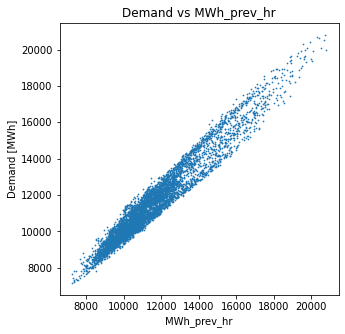

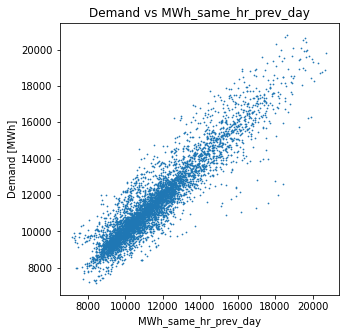

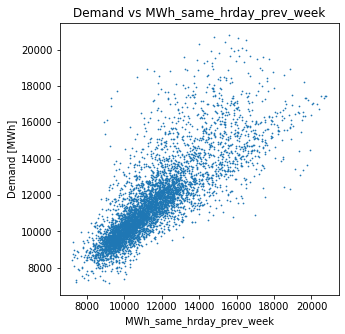

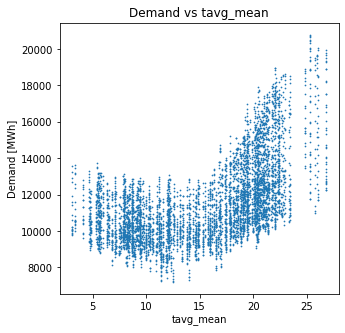

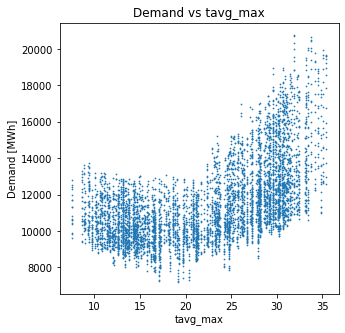

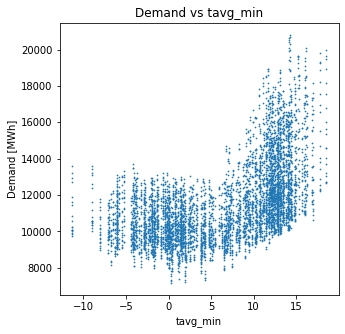

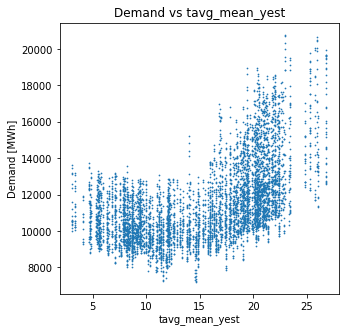

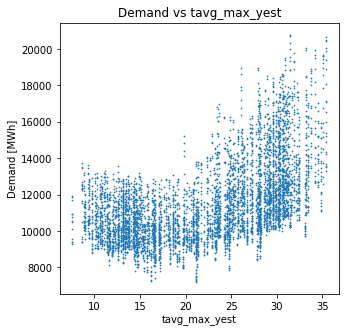

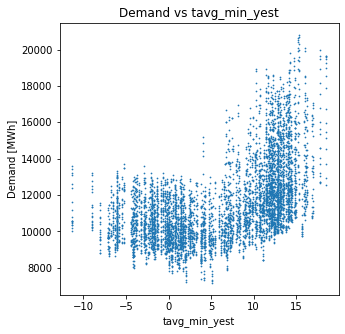

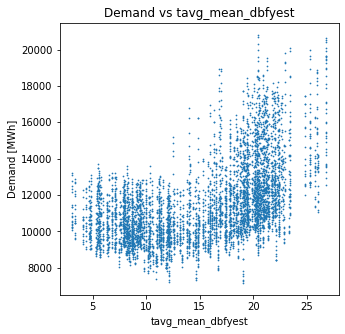

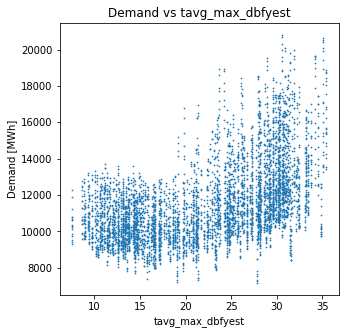

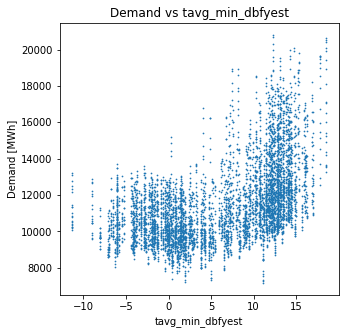

In [51]:
# Plot demand MWh vs. potential features to visualize relationships (for all train data)
for var in potential_features:
    plt.scatter(train[var], train['MWh'], s = 0.5)
    plt.title('Demand vs '+var)
    plt.xlabel(var)
    plt.ylabel('Demand [MWh]')
    plt.show()

While the relationships between hourly demand and historical demand variables were linear, those between hourly demand and temperatures were not. As a result, they were transformed based on the transformations appropriate for the lower right quadrant of the Tukey-Mosteller diagram, in order to linearize the relationships (i.e., feature engineering). 

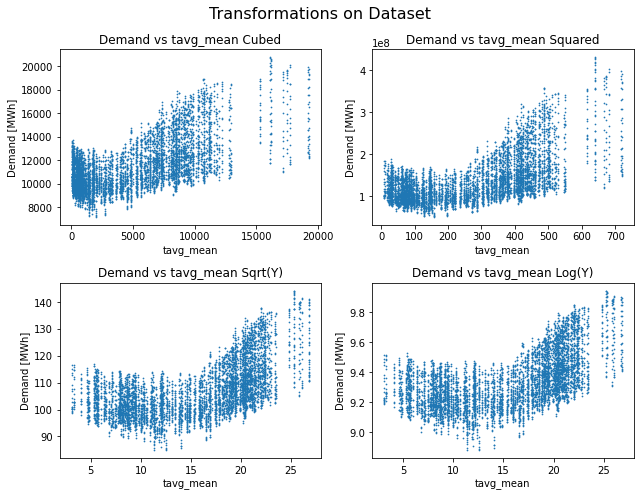

In [52]:
# Plot demand MWh vs. tavg_mean, transformed in 4 ways based on 
# shape of untransformed plot & Tukey-Mosteller Bulge diagram
# Based on plots, x cubed transformation appears to get closest to linearizing the relationship
def transform_plots(df, xvar, yvar):
    """
    Purpose: Applies transformations appropriate for lower right quadrant of Tukey-Mosteller Bulge Diagram
    Inputs: DataFrame, name of column to treat as x variable, name of column to treat as y-variable
    Outputs: Transformed plots
    """
    fig = plt.figure(figsize = (9, 7))
    fig.suptitle('Transformations on Dataset', fontsize = 16)
    fig_names = ['Cubed', 'Squared', 'Sqrt(Y)', 'Log(Y)']
    transf_x = [df[xvar]**3, df[xvar]**2, df[xvar], df[xvar]]
    transf_y = [df[yvar], df[yvar]**2, np.sqrt(df[yvar]), np.log(df[yvar])]
    for i in np.arange(4):
        ax = fig.add_subplot(2, 2, i+1)
        ax.scatter(transf_x[i], transf_y[i], s = 0.5)
        ax.set_title('Demand vs '+xvar+' '+fig_names[i])
        ax.set_xlabel(xvar)
        ax.set_ylabel('Demand [MWh]')
    plt.tight_layout()  
    plt.show()

transform_plots(df = train, xvar = 'tavg_mean', yvar = 'MWh')
# Cubed and squared look most linear

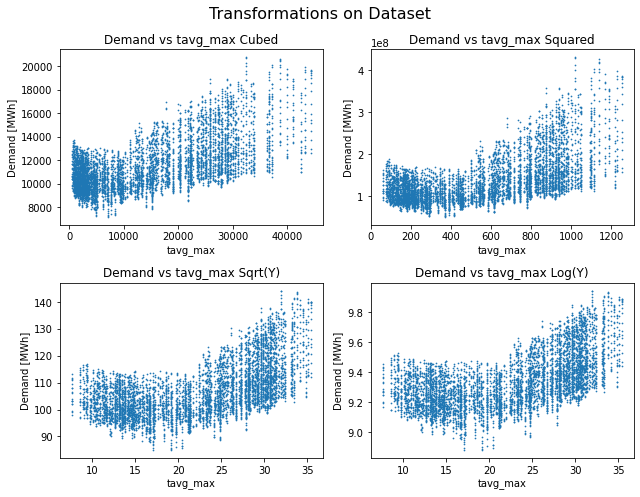

In [53]:
# Cubed and squared look most linear
transform_plots(df = train, xvar = 'tavg_max', yvar = 'MWh')

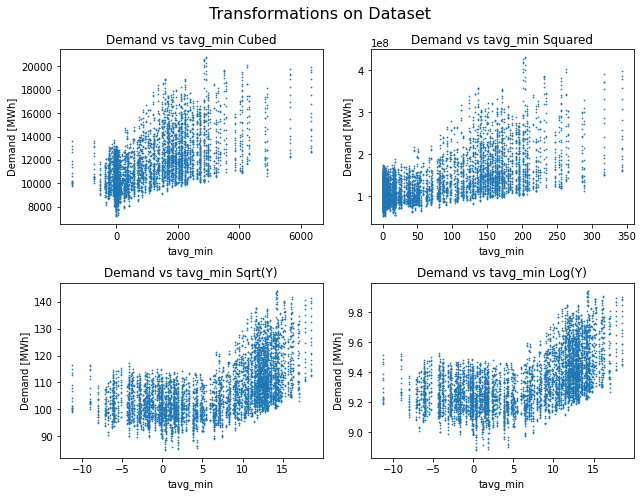

In [54]:
# Squared look most linear
transform_plots(df = train, xvar = 'tavg_min', yvar = 'MWh')

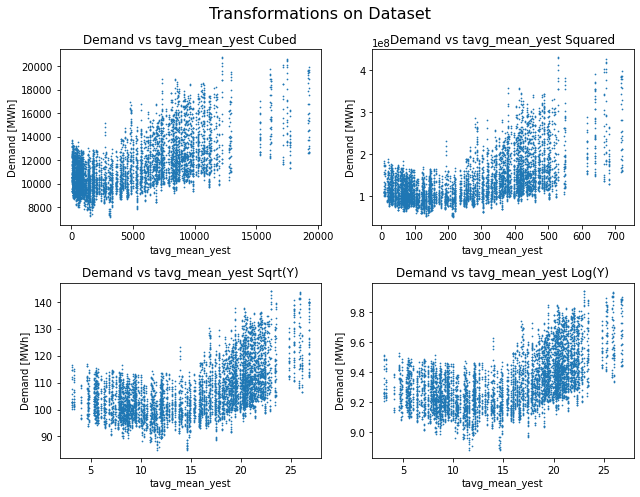

In [55]:
# Cubed and squared look most linear
transform_plots(df = train, xvar = 'tavg_mean_yest', yvar = 'MWh')

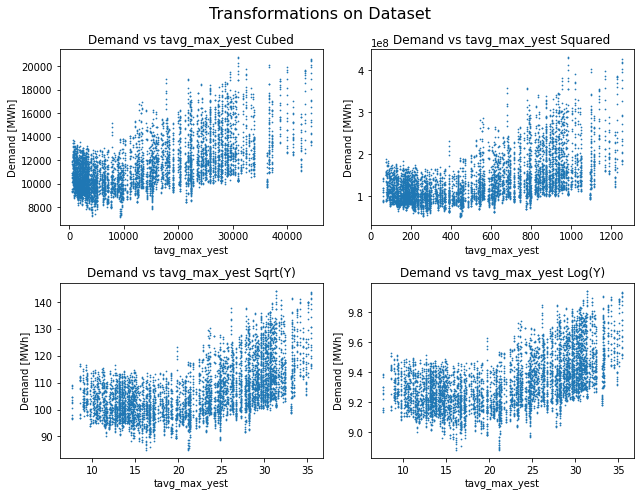

In [56]:
# Cubed and squared look most linear
transform_plots(df = train, xvar = 'tavg_max_yest', yvar = 'MWh')

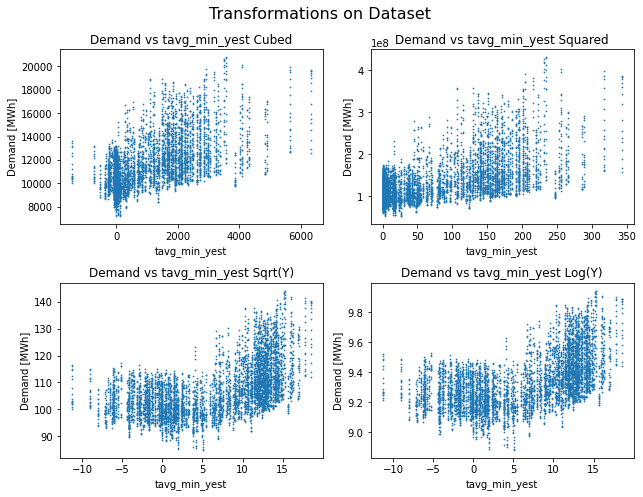

In [57]:
# Squared looks most linear
transform_plots(df = train, xvar = 'tavg_min_yest', yvar = 'MWh')

Based on the transformation exploration, the x-squared and x-cubed appear to be the most useful for our purposes, so a function was defined to facilitate pre-processing/pipeline creation.

In [58]:
# Define & run function to cube/square variables
def square_cube(df, var, power):
    labels = ['squared', 'cubed']
    sc = pd.DataFrame({(var+'_'+labels[power-2]): df[var]**power})
    return df.join(sc)

# Data Modeling: Multiple Linear Regression

Five multiple linear regression models were created to predict hourly electricity demand from temperature, historical demand, and temporal characteristics (e.g., day of week). Multiple linear regression models are designed to predict outputs based on a set of input features, therefore this model seemed appropriate. 

The features were selected based on a literature review of existing short-term electricity demand forecasts, and based on the initial exploratory data analysis conducted above that identified relationships between hourly electricity demand and historical demand, temperature, and temporal characteristics. 

Feature engineering was conducted by visualizing the relationships between the datasets and identifying transformations to linearize these relationships. Cross-validation was also conducted for each model to select features in a manner that prevents overfitting, and optimizes the model complexity and bias-variance tradeoff. 

Root mean squared error (RMSE) and R-squared figures were both used to evaluate the model. 

In [59]:
# Define functions to facilitate data preprocessing before running models
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [60]:
# Define function to calculate rmse
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [61]:
# Define function to split training data into 4 train/cross-validation sets
# Set random seed for reproducible results
np.random.seed(1337)

from sklearn.model_selection import KFold
from sklearn import linear_model as lm

def compute_CV_error(model, X_train, Y_train):
    '''
    Split training data into 4 subsets. 
    For each subset, 
        1. Fit a model holding out that subset
        2. Compute the MSE on that subset (i.e., the validation set)
    This will fit 4 models total. 
    Return average MSE of 4 folds. 
    
    Arguments: 
        model: an sklearn model with fit and predict functions
        X_train (data_frame): Training data
        Y_train (data_frame): Label
        
    Return: 
        Average validation MSE for the 4 splits'''
    kf = KFold(n_splits = 4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train): 
        # Split data
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]
        
        # Fit model on training split
        model.fit(split_X_train, split_Y_train)
        
        error = rmse(model.predict(split_X_valid), split_Y_valid)
        
        validation_errors.append(error)
        
    return np.mean(validation_errors)

**Model 1: Load & Temperature Variables as Features**

In [62]:
cols_m1 = ['MWh', 'MWh_prev_hr', 'MWh_same_hr_prev_day', 'MWh_same_hrday_prev_week',
            'tavg_mean_cubed', 'tavg_max_cubed', 'tavg_min_squared', 'tavg_mean_yest_cubed', 
            'tavg_max_yest_cubed', 'tavg_min_yest_squared']

In [63]:
# Preprocess data for model
pipeline = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
            (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}), 
            (select_columns, cols_m1, None)]

X_train, y_train = process_data_gm(train, pipeline, 'MWh')
X_test, y_test = process_data_gm(test, pipeline, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train[:, :N], y_train)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 516.0945373336194
Trying first 2 features
	RMSE: 457.5167186216717
Trying first 3 features
	RMSE: 449.02899899083855
Trying first 4 features
	RMSE: 447.17280129837474
Trying first 5 features
	RMSE: 444.33107323753165
Trying first 6 features
	RMSE: 443.18250550257375
Trying first 7 features
	RMSE: 429.82860804926884
Trying first 8 features
	RMSE: 430.01102209175406
Trying first 9 features
	RMSE: 430.1194596808362
Best choice, use the first 7 features


In [64]:
# Re-create model using first 7 features based on cross-validation results
pipeline = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
            (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
            (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}), 
            (select_columns, cols_m1[0:7+1], None)]

X_train, y_train = process_data_gm(train, pipeline, 'MWh')
X_test, y_test = process_data_gm(test, pipeline, 'MWh')

linear_model = lm.LinearRegression(fit_intercept=True)
y_fitted = linear_model.fit(X_train, y_train).predict(X_train)
y_predicted = linear_model.predict(X_test)

In [65]:
# Compute training and test errors for the model
training_error = rmse(y_fitted, y_train)
test_error = rmse(y_predicted, y_test)
print("Model\nTraining RMSE: {}\nTest RMSE: {}".format(training_error, test_error))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error/np.mean(y_test))

# Calculated multiple R^2
R_squared_train = (np.std(y_fitted)**2)/(np.std(y_train)**2)
R_squared_test = (np.std(y_predicted)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train)
print("Testing R-squared: ", R_squared_test)

# Look at model parameters
print('intercept term: ', linear_model.intercept_)
parameters = cols_m1[1:7+1]
for i in np.arange(len(parameters)):
    print(parameters[i], ': ', "{:.4f}".format(linear_model.coef_[i]))
    
# Create dataframe of model results
results = pd.DataFrame({'Model': ['Model 1'], 
                       'RMSE': test_error.astype(int),
                       'RMSE/mean hrly demand': (test_error/np.mean(y_test)).round(3), 
                       'R-squared': R_squared_test.round(3)})
results

Model
Training RMSE: 428.9963913721007
Test RMSE: 436.9744490202475

Training error/mean hourly demand:  0.03716541776792486
Testing error/mean hourly demand:  0.03793245384039102

Training R-squared:  0.9613753523221988
Testing R-squared:  0.9698700856544655
intercept term:  -90.46519375838398
MWh_prev_hr :  0.6373
MWh_same_hr_prev_day :  0.2884
MWh_same_hrday_prev_week :  0.0796
tavg_mean_cubed :  0.1305
tavg_max_cubed :  -0.0004
tavg_min_squared :  -1.3107
tavg_mean_yest_cubed :  -0.1003


,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.97


**Model 2: Load & Temporal Variables**

In [66]:
# Define one hot encoding function
from sklearn.preprocessing import OneHotEncoder

def ohe(df, col, col_names):
    """
    One-hot-encodes chosen column.  New columns are of the form 0x_QUALITY.
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(df[[col]])
    dummies = pd.DataFrame(oh_enc.transform(df[[col]]).todense(), 
                           columns=col_names,
                           index = df.index)
    return df.join(dummies)

In [67]:
# Create list of column names for y columns plus design matrix for pipeline function
hours = np.arange(0, 24)
days = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct']
cols_m2 = ['MWh', 'MWh_prev_hr', 'MWh_same_hr_prev_day', 'MWh_same_hrday_prev_week']
cols_m2.extend(hours)
cols_m2.extend(days)
cols_m2.extend(months)

In [68]:
# Preprocess data for model
pipeline_2 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m2, None)]

# Create train & test matrices
X_train_2, y_train_2 = process_data_gm(train, pipeline_2, 'MWh')
X_test_2, y_test_2 = process_data_gm(test, pipeline_2, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train_2.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train_2[:, :N], y_train_2)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 516.0945373336194
Trying first 2 features
	RMSE: 457.5167186216717
Trying first 3 features
	RMSE: 449.02899899083855
Trying first 4 features
	RMSE: 429.8394858561171
Trying first 5 features
	RMSE: 419.42461181956764
Trying first 6 features
	RMSE: 412.4143463111673
Trying first 7 features
	RMSE: 408.098161158247
Trying first 8 features
	RMSE: 405.6753467167357
Trying first 9 features
	RMSE: 405.49908732571896
Trying first 10 features
	RMSE: 404.43206084155787
Trying first 11 features
	RMSE: 399.01248127601286
Trying first 12 features
	RMSE: 395.28978731959484
Trying first 13 features
	RMSE: 395.32929196770743
Trying first 14 features
	RMSE: 393.8101228755652
Trying first 15 features
	RMSE: 392.302767569496
Trying first 16 features
	RMSE: 391.7141803169576
Trying first 17 features
	RMSE: 391.6345574127252
Trying first 18 features
	RMSE: 391.16975591322876
Trying first 19 features
	RMSE: 388.78234027668344
Trying first 20 features
	RMSE: 382.0710065221312
Tr

In [69]:
# Re-create model using first 32 features based on cross-validation results
pipeline_2 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (select_columns, cols_m2[0:32+1], None)]

X_train_2, y_train_2 = process_data_gm(train, pipeline_2, 'MWh')
X_test_2, y_test_2 = process_data_gm(test, pipeline_2, 'MWh')

# Initialize sklearn linear regression, fit model, & compute predicted values
linear_model_2 = lm.LinearRegression(fit_intercept=True)
y_fitted_2 = linear_model_2.fit(X_train_2, y_train_2).predict(X_train_2)
y_predicted_2 = linear_model_2.predict(X_test_2)

In [70]:
# Compute training and test errors for the model
training_error_2 = rmse(y_fitted_2, y_train_2)
test_error_2 = rmse(y_predicted_2, y_test_2)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error_2, test_error_2))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error_2/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error_2/np.mean(y_test))

# Calculated multiple R^2
R_squared_train_2 = (np.std(y_fitted_2)**2)/(np.std(y_train)**2)
R_squared_test_2 = (np.std(y_predicted_2)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train_2)
print("Testing R-squared: ", R_squared_test_2)

# Look at model parameters
print('intercept term: ', linear_model_2.intercept_)
parameters_2 = cols_m2[1:32+1]
for i in np.arange(len(parameters_2)):
    print(parameters_2[i], ': ', "{:.4f}".format(linear_model_2.coef_[i]))
    
    
# Create dataframe of model results
results = results.append({'Model': 'Model 2', 
                         'RMSE': test_error_2.astype(int),
                         'RMSE/mean hrly demand': (test_error_2/np.mean(y_test)).round(3), 
                         'R-squared': R_squared_test_2.round(3)}, ignore_index = True)
results

Training RMSE: 267.3207094571918
Test RMSE: 270.435657101534

Training error/mean hourly demand:  0.023158903069599838
Testing error/mean hourly demand:  0.02347571603511405

Training R-squared:  0.9850023763670648
Testing R-squared:  0.9805544316683604
intercept term:  21903494744.99355
MWh_prev_hr :  0.9028
MWh_same_hr_prev_day :  0.0799
MWh_same_hrday_prev_week :  0.0150
0 :  -21903495531.9373
1 :  -21903495275.7484
2 :  -21903495143.4209
3 :  -21903495013.3059
4 :  -21903494894.9936
5 :  -21903494703.2152
6 :  -21903494458.1111
7 :  -21903494280.3801
8 :  -21903494394.8741
9 :  -21903494685.5903
10 :  -21903494894.4813
11 :  -21903494879.6524
12 :  -21903494787.1129
13 :  -21903494698.9652
14 :  -21903494532.8797
15 :  -21903494421.8897
16 :  -21903494340.0562
17 :  -21903494216.9575
18 :  -21903494105.9227
19 :  -21903494357.6378
20 :  -21903494732.7381
21 :  -21903495008.6067
22 :  -21903495282.9700
23 :  -21903495568.1938
mon :  135.1868
tues :  56.2781
wed :  48.0784
thurs :  4

,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.970
1,Model 2,270,0.023,0.981


**Model 3: Load, Temperature, & Temporal Variables**

In [71]:
# Create list of column names for y columns plus design matrix for pipeline function
temp = ['tavg_mean_cubed', 'tavg_max_cubed', 'tavg_min_squared', 
        'tavg_mean_yest_cubed', 'tavg_max_yest_cubed', 'tavg_min_yest_squared']
cols_m3 = ['MWh', 'MWh_prev_hr', 'MWh_same_hr_prev_day', 'MWh_same_hrday_prev_week']
                                
cols_m3.extend(temp)
cols_m3.extend(days)
cols_m3.extend(hours)
cols_m3.extend(months)

In [72]:
# Preprocess data for model
pipeline_3 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m3, None)]

# Create train and test matrices
X_train_3, y_train_3 = process_data_gm(train, pipeline_3, 'MWh')
X_test_3, y_test_3 = process_data_gm(test, pipeline_3, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train_3.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train_3[:, :N], y_train_3)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 516.0945373336194
Trying first 2 features
	RMSE: 457.5167186216717
Trying first 3 features
	RMSE: 449.02899899083855
Trying first 4 features
	RMSE: 447.17280129837474
Trying first 5 features
	RMSE: 444.33107323753165
Trying first 6 features
	RMSE: 443.18250550257375
Trying first 7 features
	RMSE: 429.82860804926884
Trying first 8 features
	RMSE: 430.01102209175406
Trying first 9 features
	RMSE: 430.1194596808362
Trying first 10 features
	RMSE: 412.4974400866178
Trying first 11 features
	RMSE: 409.69929801000654
Trying first 12 features
	RMSE: 408.8798809508008
Trying first 13 features
	RMSE: 406.6969557700523
Trying first 14 features
	RMSE: 406.27366887091796
Trying first 15 features
	RMSE: 406.0676227867595
Trying first 16 features
	RMSE: 406.0676227867595
Trying first 17 features
	RMSE: 392.41825187333967
Trying first 18 features
	RMSE: 384.68050655915795
Trying first 19 features
	RMSE: 379.18808608354703
Trying first 20 features
	RMSE: 375.587795936579

In [73]:
# Recreate model using first 49 features based on results from cross-validation
pipeline_3 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m3[0:49+1], None)]

# Create train and test matrices
X_train_3, y_train_3 = process_data_gm(train, pipeline_3, 'MWh')
X_test_3, y_test_3 = process_data_gm(test, pipeline_3, 'MWh')

# Initialize sklearn linear regression, fit model, & compute predicted values
linear_model_3 = lm.LinearRegression(fit_intercept=True)
y_fitted_3 = linear_model_3.fit(X_train_3, y_train_3).predict(X_train_3)
y_predicted_3 = linear_model_3.predict(X_test_3)

# Compute training and test errors for the model
training_error_3 = rmse(y_fitted_3, y_train_3)
test_error_3 = rmse(y_predicted_3, y_test_3)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error_3, test_error_3))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error_3/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error_3/np.mean(y_test))

# Calculated multiple R^2
R_squared_train_3 = (np.std(y_fitted_3)**2)/(np.std(y_train)**2)
R_squared_test_3 = (np.std(y_predicted_3)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train_3)
print("Testing R-squared: ", R_squared_test_3)

# Look at model parameters
print('intercept term: ', linear_model_3.intercept_)
parameters_3 = cols_m3[1:49+1]
for i in np.arange(len(parameters_3)):
    print(parameters_3[i], ': ', "{:.4f}".format(linear_model_3.coef_[i]))

# Create dataframe of model results
results = results.append({'Model': 'Model 3', 
                         'RMSE': test_error_3.astype(int),
                         'RMSE/mean hrly demand': (test_error_3/np.mean(y_test)).round(3), 
                         'R-squared': R_squared_test_3.round(3)}, ignore_index = True)
results

Training RMSE: 260.78642067797085
Test RMSE: 264.1608049675876

Training error/mean hourly demand:  0.022592815388723826
Testing error/mean hourly demand:  0.02293101476148152

Training R-squared:  0.9857266077716794
Testing R-squared:  0.9826443829325616
intercept term:  45.9642319781542
MWh_prev_hr :  0.8480
MWh_same_hr_prev_day :  0.1163
MWh_same_hrday_prev_week :  0.0224
tavg_mean_cubed :  0.0657
tavg_max_cubed :  -0.0044
tavg_min_squared :  -0.1652
tavg_mean_yest_cubed :  -0.0409
tavg_max_yest_cubed :  0.0010
tavg_min_yest_squared :  -0.0786
mon :  124.5841
tues :  28.3613
wed :  4.0920
thurs :  2.1532
fri :  -29.0112
sat :  -73.5454
sun :  -56.6340
0 :  -728.2287
1 :  -494.3179
2 :  -375.7305
3 :  -256.4780
4 :  -148.8117
5 :  32.6896
6 :  268.4198
7 :  438.6356
8 :  341.1417
9 :  66.8357
10 :  -131.1753
11 :  -119.9165
12 :  -35.8738
13 :  49.9126
14 :  209.0710
15 :  318.5225
16 :  399.2631
17 :  520.9327
18 :  634.2351
19 :  403.6087
20 :  51.0271
21 :  -212.9991
22 :  -475.60

,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.970
1,Model 2,270,0.023,0.981
2,Model 3,264,0.023,0.983


**Model 3 using dataset with outliers removed**

In [74]:
# Create train and test data
X_train_3_no, y_train_3_no = process_data_gm(train_wo_outliers, pipeline_3, 'MWh')
X_test_3_no, y_test_3_no = process_data_gm(test_wo_outliers, pipeline_3, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train_3_no.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train_3_no[:, :N], y_train_3_no)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 511.9911422441125
Trying first 2 features
	RMSE: 454.8444800125391
Trying first 3 features
	RMSE: 442.57553184200924
Trying first 4 features
	RMSE: 441.2478419933806
Trying first 5 features
	RMSE: 439.30160496617157
Trying first 6 features
	RMSE: 438.92188214007393
Trying first 7 features
	RMSE: 426.52630161972576
Trying first 8 features
	RMSE: 426.5253203121544
Trying first 9 features
	RMSE: 426.560869949857
Trying first 10 features
	RMSE: 409.34540431148355
Trying first 11 features
	RMSE: 407.1572732218784
Trying first 12 features
	RMSE: 406.0626739366551
Trying first 13 features
	RMSE: 403.79552025641885
Trying first 14 features
	RMSE: 403.09209163083005
Trying first 15 features
	RMSE: 403.12584182846217
Trying first 16 features
	RMSE: 403.12584182846217
Trying first 17 features
	RMSE: 388.33160778905903
Trying first 18 features
	RMSE: 381.2044395834361
Trying first 19 features
	RMSE: 376.10694677750314
Trying first 20 features
	RMSE: 372.8909349199353

In [75]:
# Cross-validation recommended using all 50 features, so initialize model using same pipeline
# Initialize sklearn linear regression, fit model, & compute predicted values
linear_model_3_no = lm.LinearRegression(fit_intercept=True)
y_fitted_3_no = linear_model_3_no.fit(X_train_3_no, y_train_3_no).predict(X_train_3_no)
y_predicted_3_no = linear_model_3_no.predict(X_test_3_no)

# Compute training and test errors for the model
training_error_3_no = rmse(y_fitted_3_no, y_train_3_no)
test_error_3_no = rmse(y_predicted_3_no, y_test_3_no)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error_3_no, test_error_3_no))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error_3_no/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error_3_no/np.mean(y_test))

# Calculated multiple R^2
R_squared_train_3_no = (np.std(y_fitted_3_no)**2)/(np.std(y_train)**2)
R_squared_test_3_no = (np.std(y_predicted_3_no)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train_3_no)
print("Testing R-squared: ", R_squared_test_3_no)

# Look at model parameters
print('\nintercept term: ', linear_model_3_no.intercept_)
parameters_3_no = cols_m3[1:49+1]
for i in np.arange(len(parameters_3_no)):
    print(parameters_3_no[i], ': ', "{:.4f}".format(linear_model_3_no.coef_[i]))
    
# Create dataframe of model results
results = results.append({'Model': 'Model 3 w/o Outliers', 
                         'RMSE': test_error_3_no.astype(int),
                         'RMSE/mean hrly demand': (test_error_3_no/np.mean(y_test)).round(3), 
                         'R-squared': R_squared_test_3_no.round(3)}, ignore_index = True)
results

Training RMSE: 256.92385137563866
Test RMSE: 253.6561530316506

Training error/mean hourly demand:  0.02225818786115979
Testing error/mean hourly demand:  0.022019137132108183

Training R-squared:  0.9484158157878063
Testing R-squared:  0.918664605403471

intercept term:  7.290909203278716
MWh_prev_hr :  0.8461
MWh_same_hr_prev_day :  0.1161
MWh_same_hrday_prev_week :  0.0276
tavg_mean_cubed :  0.0741
tavg_max_cubed :  -0.0061
tavg_min_squared :  -0.2694
tavg_mean_yest_cubed :  -0.0512
tavg_max_yest_cubed :  0.0040
tavg_min_yest_squared :  0.0660
mon :  125.6372
tues :  21.6077
wed :  6.7068
thurs :  2.1836
fri :  -26.4987
sat :  -73.7467
sun :  -55.8899
0 :  -730.1849
1 :  -480.3021
2 :  -359.3800
3 :  -248.0250
4 :  -137.3588
5 :  43.2598
6 :  276.0664
7 :  442.0157
8 :  338.5721
9 :  61.4460
10 :  -139.3517
11 :  -131.2515
12 :  -51.7041
13 :  43.5084
14 :  196.3933
15 :  316.5605
16 :  396.2252
17 :  509.9174
18 :  636.1144
19 :  411.4698
20 :  52.2060
21 :  -220.9133
22 :  -474.53

,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.970
1,Model 2,270,0.023,0.981
2,Model 3,264,0.023,0.983
3,Model 3 w/o Outliers,253,0.022,0.919


**Model 3 w/o same-day (specifically previous hour) load data available**

In [76]:
# Create list of column names for y columns plus design matrix for pipeline function
# cols_m4_1 excludes same day load data
cols_m4_1 = ['MWh', 'MWh_same_hr_prev_day', 'MWh_same_hrday_prev_week']                 
cols_m4_1.extend(temp)
cols_m4_1.extend(days)
cols_m4_1.extend(hours)
cols_m4_1.extend(months)

# Version where temperature variables come before months
# cols_m4_2 excludes same day and previous day load data
cols_m4_2 = ['MWh', 'MWh_same_hrday_prev_week']
cols_m4_2.extend(temp)
cols_m4_2.extend(days)
cols_m4_2.extend(hours)
cols_m4_2.extend(months)


Model without same day load data

In [77]:
# Preprocess data for model (excludes same day load data)
pipeline_4_1 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m4_1, None)]

X_train_4_1, y_train_4_1 = process_data_gm(train, pipeline_4_1, 'MWh')
X_test_4_1, y_test_4_1 = process_data_gm(test, pipeline_4_1, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train_4_1.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train_4_1[:, :N], y_train_4_1)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 820.2472079575
Trying first 2 features
	RMSE: 756.3623931350112
Trying first 3 features
	RMSE: 728.1520931601718
Trying first 4 features
	RMSE: 718.8153212927044
Trying first 5 features
	RMSE: 713.7273028091631
Trying first 6 features
	RMSE: 661.4376586436481
Trying first 7 features
	RMSE: 661.701831379437
Trying first 8 features
	RMSE: 661.8167446024476
Trying first 9 features
	RMSE: 602.2682117096791
Trying first 10 features
	RMSE: 591.161722613967
Trying first 11 features
	RMSE: 586.7579303669661
Trying first 12 features
	RMSE: 578.8281647415573
Trying first 13 features
	RMSE: 576.3272677397036
Trying first 14 features
	RMSE: 575.9954258964759
Trying first 15 features
	RMSE: 575.995425896476
Trying first 16 features
	RMSE: 575.9877226599947
Trying first 17 features
	RMSE: 576.113589173757
Trying first 18 features
	RMSE: 575.9604193154295
Trying first 19 features
	RMSE: 575.6660981382299
Trying first 20 features
	RMSE: 575.0778389056405
Trying first 21 

In [78]:
# Recreate model using first 48 features based on results from cross-validation (excludes same day load data)
pipeline_4_1 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m4_1[0:48+1], None)]

X_train_4_1, y_train_4_1 = process_data_gm(train, pipeline_4_1, 'MWh')
X_test_4_1, y_test_4_1 = process_data_gm(test, pipeline_4_1, 'MWh')

# Initialize model, fit model, & compute predicted values
linear_model_4_1 = lm.LinearRegression(fit_intercept=True)
y_fitted_4_1 = linear_model_4_1.fit(X_train_4_1, y_train_4_1).predict(X_train_4_1)
y_predicted_4_1 = linear_model_4_1.predict(X_test_4_1)

# Compute training and test errors for the model
training_error_4_1 = rmse(y_fitted_4_1, y_train_4_1)
test_error_4_1 = rmse(y_predicted_4_1, y_test_4_1)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error_4_1, test_error_4_1))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error_3/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error_3/np.mean(y_test))

# Calculated multiple R^2
R_squared_train_4_1 = (np.std(y_fitted_4_1)**2)/(np.std(y_train)**2)
R_squared_test_4_1 = (np.std(y_predicted_4_1)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train_4_1)
print("Testing R-squared: ", R_squared_test_4_1)

# Create dataframe of model results
results = results.append({'Model': 'Model 3 w/o same day load data', 
                         'RMSE': test_error_4_1.astype(int),
                         'RMSE/mean hrly demand': (test_error_4_1/np.mean(y_test)).round(3), 
                         'R-squared': R_squared_test_4_1.round(3)}, ignore_index = True)
results

Training RMSE: 551.6531527423101
Test RMSE: 548.8778625088612

Training error/mean hourly demand:  0.022592815388723826
Testing error/mean hourly demand:  0.02293101476148152

Training R-squared:  0.9361310978516513
Testing R-squared:  0.9493775207673102


,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.970
1,Model 2,270,0.023,0.981
2,Model 3,264,0.023,0.983
3,Model 3 w/o Outliers,253,0.022,0.919
4,Model 3 w/o same day load data,548,0.048,0.949


**Model 3 w/o same- or previous-day (specifically previous hour or previous day same hour) load data available**

In [79]:
# Preprocess data for model  (excludes same day and previous day load data)
pipeline_4_2 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m4_2, None)]

X_train_4_2, y_train_4_2 = process_data_gm(train, pipeline_4_2, 'MWh')
X_test_4_2, y_test_4_2 = process_data_gm(test, pipeline_4_2, 'MWh')

# Use compute_CV_error to determine how many of first N features should use to get lowest average validation error
# Set random seed for reproducible results
np.random.seed(1337)

errors = []
range_of_num_features = range(1, X_train_4_2.shape[1] + 1)

for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train_4_2[:, :N], y_train_4_2)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 1273.8045990876365
Trying first 2 features
	RMSE: 1095.6657615811646
Trying first 3 features
	RMSE: 1095.8151705512998
Trying first 4 features
	RMSE: 1084.0072385032784
Trying first 5 features
	RMSE: 1081.2826327200341
Trying first 6 features
	RMSE: 1082.2386240763724
Trying first 7 features
	RMSE: 1080.5776221819353
Trying first 8 features
	RMSE: 1080.9116306698375
Trying first 9 features
	RMSE: 1079.843460163162
Trying first 10 features
	RMSE: 1079.673742494322
Trying first 11 features
	RMSE: 1077.9834142670786
Trying first 12 features
	RMSE: 1077.3918948099886
Trying first 13 features
	RMSE: 1077.1508211711316
Trying first 14 features
	RMSE: 1077.1508211711314
Trying first 15 features
	RMSE: 1076.6739532804854
Trying first 16 features
	RMSE: 1074.2449937620809
Trying first 17 features
	RMSE: 1069.394799085605
Trying first 18 features
	RMSE: 1061.9655201182754
Trying first 19 features
	RMSE: 1049.9198028297503
Trying first 20 features
	RMSE: 1037.839791

In [80]:
# Recreate model using first 47 features based on results from cross-validation  
# (excludes same day & previous day load data)
pipeline_4_2 = [(square_cube, None, {'var': 'tavg_mean', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min', 'power': 2}), 
              (square_cube, None, {'var': 'tavg_mean_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_max_yest', 'power': 3}), 
              (square_cube, None, {'var': 'tavg_min_yest', 'power': 2}),
              (ohe, None, {'col': 'hour', 'col_names': hours}),
              (ohe, None, {'col': 'day_of_week', 'col_names': days}),
              (ohe, None, {'col': 'month', 'col_names': months}),
              (select_columns, cols_m4_2[0:47+1], None)]

X_train_4_2, y_train_4_2 = process_data_gm(train, pipeline_4_2, 'MWh')
X_test_4_2, y_test_4_2 = process_data_gm(test, pipeline_4_2, 'MWh')

# Initialize model, fit model, & compute predicted values
linear_model_4_2 = lm.LinearRegression(fit_intercept=True)
y_fitted_4_2 = linear_model_4_2.fit(X_train_4_2, y_train_4_2).predict(X_train_4_2)
y_predicted_4_2 = linear_model_4_2.predict(X_test_4_2)

# Compute training and test errors for the model
training_error_4_2 = rmse(y_fitted_4_2, y_train_4_2)
test_error_4_2 = rmse(y_predicted_4_2, y_test_4_2)
print("Training RMSE: {}\nTest RMSE: {}".format(training_error_4_2, test_error_4_2))

# Calculate RMSE as a percentage of mean hourly demand
print("\nTraining error/mean hourly demand: ", training_error_3/np.mean(y_train))
print("Testing error/mean hourly demand: ", test_error_3/np.mean(y_test))

# Calculated multiple R^2
R_squared_train_4_2 = (np.std(y_fitted_4_2)**2)/(np.std(y_train)**2)
R_squared_test_4_2 = (np.std(y_predicted_4_2)**2)/(np.std(y_test)**2)
print("\nTraining R-squared: ", R_squared_train_4_2)
print("Testing R-squared: ", R_squared_test_4_2)

# Create dataframe of model results
results = results.append({'Model': 'Model 3 w/o same or previous day load data', 
                         'RMSE': test_error_4_2.astype(int),
                         'RMSE/mean hrly demand': (test_error_4_2/np.mean(y_test)).round(3), 
                         'R-squared': R_squared_test_4_2.round(3)}, ignore_index = True)
results

Training RMSE: 790.7314368363994
Test RMSE: 798.2385599555911

Training error/mean hourly demand:  0.022592815388723826
Testing error/mean hourly demand:  0.02293101476148152

Training R-squared:  0.8687753960055326
Testing R-squared:  0.9145879248542121


,Model,RMSE,RMSE/mean hrly demand,R-squared
0,Model 1,436,0.038,0.970
1,Model 2,270,0.023,0.981
2,Model 3,264,0.023,0.983
3,Model 3 w/o Outliers,253,0.022,0.919
4,Model 3 w/o same day load data,548,0.048,0.949
5,Model 3 w/o same or previous day load data,798,0.069,0.915


**Plotting predicted vs. actual for all five models**

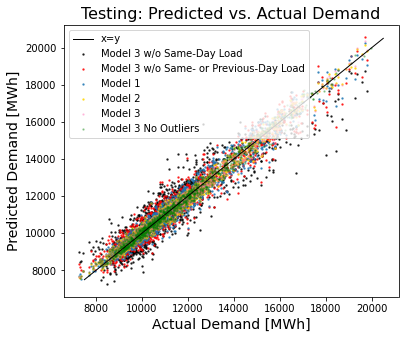

In [81]:
# Plot actual vs. predicted for testing set
plt.rcParams["figure.figsize"] = (6,5)
plt.scatter(y_test_4_2, y_predicted_4_2, s = 2, alpha = 0.7, label = 'Model 3 w/o Same-Day Load', c = 'black')
plt.scatter(y_test_4_1, y_predicted_4_1, s = 2, alpha = 0.7, label = 'Model 3 w/o Same- or Previous-Day Load', c = 'red')
plt.scatter(y_test, y_predicted, s = 2, alpha = 0.7, label = 'Model 1')
plt.scatter(y_test_2, y_predicted_2, s = 2, alpha = 0.7, label = 'Model 2', c = 'gold')
plt.scatter(y_test_3, y_predicted_3, s = 2, alpha = 0.3, label = 'Model 3', c = 'hotpink')
plt.scatter(y_test_3_no, y_predicted_3_no, s = 2, alpha = 0.3, label = 'Model 3 No Outliers', c = 'green')
plt.plot([7500, 20500], [7500, 20500], c = 'black', linewidth = 1, label = 'x=y')
plt.title('Testing: Predicted vs. Actual Demand', fontsize = 16)
plt.xlabel('Actual Demand [MWh]', fontsize = 14)
plt.ylabel('Predicted Demand [MWh]', fontsize = 14)
plt.legend()
plt.show()

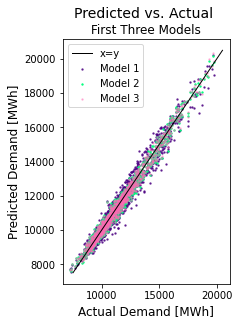

In [82]:
# Plot actual vs. predicted for testing set
plt.rcParams["figure.figsize"] = (3,4.5)
plt.scatter(y_test, y_predicted, s = 2, alpha = 0.7, label = 'Model 1', c = 'indigo')
plt.scatter(y_test_2, y_predicted_2, s = 2, alpha = 0.9, label = 'Model 2', c = 'springgreen')
plt.scatter(y_test_3, y_predicted_3, s = 2, alpha = 0.4, label = 'Model 3', c = 'hotpink')
plt.plot([7500, 20500], [7500, 20500], c = 'black', linewidth = 1, label = 'x=y')
plt.suptitle('Predicted vs. Actual', fontsize = 14)
plt.title('First Three Models', fontsize = 12)
plt.xlabel('Actual Demand [MWh]', fontsize = 12)
plt.ylabel('Predicted Demand [MWh]', fontsize = 12)
plt.legend()
plt.show()

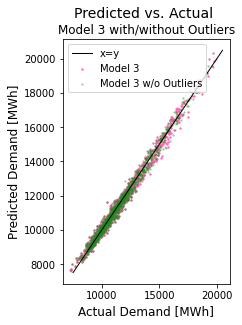

In [83]:
# Plot actual vs. predicted for testing set
plt.rcParams["figure.figsize"] = (3, 4.5)
plt.scatter(y_test_3, y_predicted_3, s = 2, alpha = 0.9, label = 'Model 3', c = 'hotpink')
plt.scatter(y_test_3_no, y_predicted_3_no, s = 2, alpha = 0.3, label = 'Model 3 w/o Outliers', c = 'forestgreen')
plt.plot([7500, 20500], [7500, 20500], c = 'black', linewidth = 1, label = 'x=y')
plt.suptitle('Predicted vs. Actual', fontsize = 14)
plt.title('Model 3 with/without Outliers', fontsize = 12)
plt.xlabel('Actual Demand [MWh]', fontsize = 12)
plt.ylabel('Predicted Demand [MWh]', fontsize = 12)
plt.legend()
plt.show()

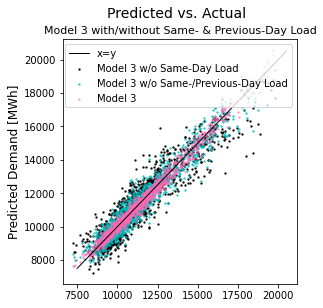

In [84]:
# Plot actual vs. predicted for testing set
plt.rcParams["figure.figsize"] = (4.2,4.5)
plt.scatter(y_test_4_2, y_predicted_4_2, s = 2, alpha = 0.8, label = 'Model 3 w/o Same-Day Load', c = 'black')
plt.scatter(y_test_4_1, y_predicted_4_1, s = 2, alpha = 0.7, label = 'Model 3 w/o Same-/Previous-Day Load', c = 'c')
plt.scatter(y_test_3, y_predicted_3, s = 2, alpha = 0.5, label = 'Model 3', c = 'hotpink')
plt.plot([7500, 20500], [7500, 20500], c = 'black', linewidth = 1, label = 'x=y')
plt.title('Test Data: Predicted vs. Actual', fontsize = 14)
plt.suptitle('Predicted vs. Actual', fontsize = 14)
plt.title('Model 3 with/without Same- & Previous-Day Load', fontsize = 11)
plt.ylabel('Predicted Demand [MWh]', fontsize = 12)
plt.legend()
plt.show()